# Libraries

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os
from sklearn.preprocessing import MinMaxScaler

# Diffusion model

In [ ]:
diffusion_times = 2000
n_epochs = 15
n_batch = 64

## Load dataset

/home/jgduarte/Documents/RA/chloride_ingress_probabilistic_model/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input shape: torch.Size([8, 1, 64, 64])
Labels: tensor([0.0238, 0.0288, 0.0458, 0.0851, 0.0547, 0.1927, 0.0414, 0.0263])


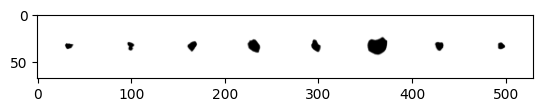

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, csv_file):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)

        q_value = self.df['diameter (mm)'].values.reshape(-1,1)
        scaler = MinMaxScaler()
        self.df['q_value_scaled'] = scaler.fit_transform(q_value).flatten()

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('L')
        image = self.transform(image)
        label = row['q_value_scaled']
        return image, torch.tensor(label, dtype=torch.float32)
    
dataset = CustomDataset('image_patchs', 'output.csv')
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
plt.show()

In [ ]:
dataset

## Trainning

In [2]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, class_emb_size=75):
        super().__init__()
        self.class_emb = nn.Linear(1, class_emb_size)  # Project scalar to embedding
        self.model = UNet2DModel(
            sample_size=64,
            in_channels=1 + class_emb_size,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 256, 256),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        embed = self.class_emb(class_labels.unsqueeze(-1))  # Add dimension for linear layer
        class_cond = embed.view(bs, embed.shape[1], 1, 1).expand(bs, embed.shape[1], w, h)
        net_input = torch.cat((x, class_cond), 1)
        return self.model(net_input, t).sample

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=diffusion_times, beta_schedule="squaredcos_cap_v2")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train_dataloader = DataLoader(dataset, batch_size=n_batch, shuffle=True)

net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []
aux = 1e9

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU (mapped to (0, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

    if avg_loss < aux:
        torch.save(net, 'diffusion_model.pt')
        aux = avg_loss

# View the loss curve
plt.plot(losses)

Using device: cuda


100%|██████████| 220/220 [04:15<00:00,  1.16s/it]


Finished epoch 0. Average of the last 100 loss values: 0.019649


100%|██████████| 220/220 [04:20<00:00,  1.18s/it]


Finished epoch 1. Average of the last 100 loss values: 0.008892


100%|██████████| 220/220 [04:20<00:00,  1.18s/it]


Finished epoch 2. Average of the last 100 loss values: 0.006385


 38%|███▊      | 84/220 [01:36<02:37,  1.15s/it]

## Save model

In [ ]:
net = torch.load(f'diffusion_model_epochs_{n_epochs}_batch_{n_batch}_diffusionTimes_{diffusion_times}.pt', weights_only=False)

## Test

1000it [00:15, 63.84it/s]


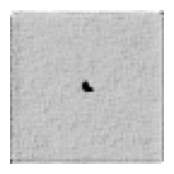

In [ ]:
# Sampling one sample:
x = torch.randn(1, 1, 64, 64).to(device)
y = torch.tensor([0.0997], dtype=torch.float32).to(device)  # Example continuous polarizability value

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample

plt.figure(figsize=(2, 2))
plt.imshow(x.detach().cpu().clip(-1,1).squeeze(), cmap="Greys")
plt.axis('off')
plt.show()

In [ ]:
(x.detach().cpu().clip(0,1).squeeze() > 0.9).int()

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

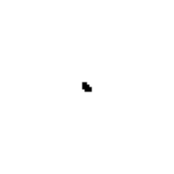

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow((x.detach().cpu().clip(0,1).squeeze() > 0.9).int(), cmap="Greys")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

for idx in range(len(dataset)):
    image, label = dataset[idx]
    if label == 0.3951528:
        plt.figure(figsize=(2,2))
        plt.imshow(image.clip(-1, 1).squeeze(), cmap='Greys')
        plt.axis('off')
        plt.show()
        plt.close()
        break